In [1]:
from pathlib import Path

import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.air import Checkpoint, session

In [2]:
SPLITS_FREQ = '1W'
ORG_NAME = 'Decentraland'

TARGET = 'ndcg@10'

# To evaluate the hybrid recommender system
BEST_HPARAMS_FILE = Path(f"./data/baseline/best-{ORG_NAME}-{SPLITS_FREQ}.csv")
REALISTIC_HPARAMS_FILE = Path(f"./data/baseline/realistic-{ORG_NAME}-{SPLITS_FREQ}.csv")

In [3]:
ray_results_path = Path("~/ray_results").expanduser()
assert ray_results_path.is_dir()

In [4]:
last_experiments = sorted(ray_results_path.glob(f'LightGCN_dao={ORG_NAME},fold=*[0-9]_*'))
print(f"Found {len(last_experiments)} experiments")

class TrainLightGCN:
    def __init__(self):
        raise NotImplementedError

tuners = [ tune.Tuner.restore(str(l), TrainLightGCN) for l in last_experiments ]
result_grids = [ tuner.get_results() for tuner in tuners ]

Found 10 experiments


In [5]:
# tune.ExperimentAnalysis(last_experiments[0], default_metric='ndcg@10', default_mode='max').trial_dataframes
pd.concat(result_grids[0]._experiment_analysis.trial_dataframes.values())

,iteration,loss,mf_loss,emb_loss,model_recall,model_ndcg,model_precision,model_map,precision@5,ndcg@5,...,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/fold,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2
0,5,0.020359,0.020272,0.000087,0.080817,0.069712,0.045000,0.047967,0.193333,0.305337,...,147.96.81.131,26.232213,1,None,0,7,300,4,0.0065,8.923120e-07
1,10,0.010209,0.010073,0.000136,0.086749,0.077871,0.053333,0.053206,0.223333,0.400848,...,147.96.81.131,53.114978,2,None,0,7,300,4,0.0065,8.923120e-07
0,5,0.410668,0.337752,0.072916,0.039623,0.029257,0.015000,0.017595,0.213333,0.340586,...,147.96.81.131,4.615137,1,None,0,8,30,5,0.2347,2.860601e-05
1,10,0.534538,0.423981,0.110557,0.028442,0.022801,0.016667,0.012485,0.205000,0.310916,...,147.96.81.131,11.486799,2,None,0,8,30,5,0.2347,2.860601e-05
0,5,0.113455,0.112978,0.000477,0.043651,0.036950,0.020000,0.028399,0.165000,0.261729,...,147.96.81.131,26.834396,1,None,0,7,215,3,0.0005,2.791926e-05
1,10,0.066501,0.065816,0.000685,0.047996,0.048636,0.025000,0.039213,0.185000,0.290346,...,147.96.81.131,52.616989,2,None,0,7,215,3,0.0005,2.791926e-05
0,5,0.195776,0.156731,0.039045,0.022778,0.019210,0.010000,0.012778,0.166667,0.270588,...,147.96.81.131,27.370045,1,None,0,7,5,4,0.0038,3.979960e-03
1,10,0.162950,0.116533,0.046417,0.049901,0.040054,0.023333,0.029515,0.186667,0.294072,...,147.96.81.131,50.634651,2,None,0,7,5,4,0.0038,3.979960e-03
0,5,0.182658,0.177392,0.005266,0.025536,0.020054,0.016667,0.010169,0.198333,0.314445,...,147.96.81.131,3.225692,1,None,0,9,5,3,0.2200,5.242816e-05
1,10,0.191687,0.185219,0.006468,0.029861,0.022097,0.010000,0.016528,0.213333,0.373841,...,147.96.81.131,8.019711,2,None,0,9,5,3,0.2200,5.242816e-05


In [6]:
# Read dataframe and drop some unneeded columns
# rdf = pd.concat([rg.get_dataframe(TARGET, 'max') for rg in result_grids ])
rdf = pd.concat([ pd.concat(rg._experiment_analysis.trial_dataframes.values()) for rg in result_grids ])

drop_cols = [
    'timestamp', 'node_ip', 'pid', 'hostname', 'time_since_restore', 'checkpoint_dir_name', 'trial_id', # 'logdir'
    'model_recall', 'model_ndcg', 'model_precision', 'model_map', 
    'time_train', 'time_test', 'time_total_s', 'time_this_iter_s',
    'training_iteration', 'iterations_since_restore',
    'recall@5', 'map@5', 'recall@10', 'map@10',
]
rdf = rdf.drop(columns=drop_cols)
rdf = rdf.drop(columns=['date']).rename(columns={'config/__trial_index__': 'config/fold', 'iteration':'config/iteration'})
# rdf = rdf[rdf['done']]
print(rdf.columns)

for c in ['config/batch_size']: #, 'config/embedding_dim']:
    rdf[c] = 2**rdf[c]

# rdf[(rdf['config/fold'] >= 1) & (rdf['iteration'] > 10)].sort_values('precision@5').tail()
rdf.sort_values(TARGET).tail()

Index(['config/iteration', 'loss', 'mf_loss', 'emb_loss', 'precision@5',
       'ndcg@5', 'precision@10', 'ndcg@10', 'time_total_train',
       'time_total_test', 'done', 'config/fold', 'config/batch_size',
       'config/embedding_dim', 'config/conv_layers', 'config/learning_rate',
       'config/l2'],
      dtype='object')


,config/iteration,loss,mf_loss,emb_loss,precision@5,ndcg@5,precision@10,ndcg@10,time_total_train,time_total_test,done,config/fold,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2
0,5,0.019521,0.019434,0.000087,0.300000,0.484350,0.235227,0.592011,35.295737,1.088782,False,1,128,300,4,0.0065,8.923120e-07
0,5,0.019521,0.019434,0.000087,0.300000,0.484350,0.235227,0.592011,24.454912,1.135678,False,1,128,300,4,0.0065,8.923120e-07
0,5,0.019303,0.019215,0.000088,0.266667,0.485198,0.208333,0.598285,28.306237,0.730749,False,3,128,300,4,0.0065,8.923120e-07
1,10,0.493711,0.379210,0.114501,0.265574,0.479723,0.206557,0.600991,14.305262,0.773311,True,7,256,30,5,0.2347,2.860601e-05
1,10,0.067471,0.066783,0.000689,0.279545,0.445733,0.245455,0.605004,65.118093,1.238513,True,1,128,215,3,0.0005,2.791926e-05


In [7]:
print(rdf['config/fold'].value_counts())
# any(rdf.groupby(config_cols)['config/fold'].size() > 1)

2    13
0    10
1    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: config/fold, dtype: int64


In [8]:
bdf = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')[-len(last_experiments):]
bdf.mean()

precision@5     0.213742
ndcg@5          0.313582
map@5           0.234635
precision@10    0.196668
ndcg@10         0.427430
map@10          0.317053
precision@15    0.170245
ndcg@15         0.498809
map@15          0.355657
dtype: float64

(0.0, 1.0)

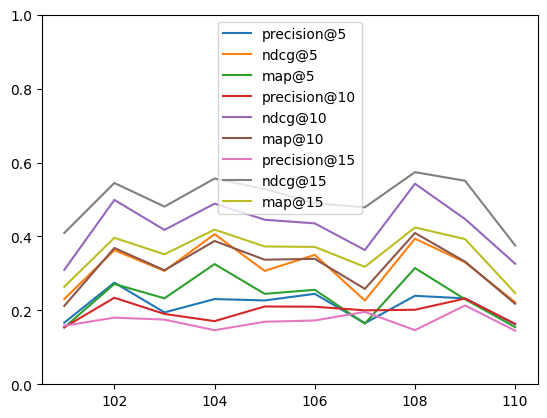

In [9]:
ax = bdf.plot()
ax.set_ylim(0, 1)

## What are the best hyperparams per fold?

In [10]:
# We fix the total time in less than 250 so it has time to do the same number of iterations with the next fold
best = rdf[rdf['time_total_train'] + rdf['time_total_test'] < 250].sort_values(TARGET).drop_duplicates('config/fold', keep='last').set_index('config/fold').sort_index()
best

,config/iteration,loss,mf_loss,emb_loss,precision@5,ndcg@5,precision@10,ndcg@10,time_total_train,time_total_test,done,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2
config/fold,,,,,,,,,,,,,,,,
0,10,0.010209,0.010073,0.000136,0.223333,0.400848,0.195000,0.503982,52.248376,0.866580,True,128,300,4,0.0065,8.923120e-07
1,10,0.067471,0.066783,0.000689,0.279545,0.445733,0.245455,0.605004,65.118093,1.238513,True,128,215,3,0.0005,2.791926e-05
2,5,0.193591,0.188178,0.005413,0.234722,0.397458,0.202778,0.480621,4.275784,1.119803,False,512,5,3,0.2200,5.242816e-05
3,5,0.019303,0.019215,0.000088,0.266667,0.485198,0.208333,0.598285,28.306237,0.730749,False,128,300,4,0.0065,8.923120e-07
4,5,0.190009,0.184598,0.005411,0.286567,0.433946,0.238806,0.587374,5.973310,1.294290,False,512,5,3,0.2200,5.242816e-05
5,10,0.515156,0.402481,0.112674,0.275000,0.445371,0.230357,0.536457,8.684578,0.744998,True,256,30,5,0.2347,2.860601e-05
6,5,0.193592,0.188146,0.005446,0.273469,0.424544,0.240816,0.534517,3.178146,0.704453,False,512,5,3,0.2200,5.242816e-05
7,10,0.493711,0.379210,0.114501,0.265574,0.479723,0.206557,0.600991,14.305262,0.773311,True,256,30,5,0.2347,2.860601e-05
8,10,0.010232,0.010088,0.000143,0.277838,0.437099,0.252432,0.539334,63.536720,0.861269,True,128,300,4,0.0065,8.923120e-07


,precision@5,ndcg@5,ndcg@10
count,10.000000,10.000000,10.000000
mean,0.260974,0.432875,0.544189
std,0.023450,0.034227,0.053175
min,0.223333,0.378828,0.455322
25%,0.242435,0.406772,0.511616
50%,0.270068,0.435522,0.537896
75%,0.277128,0.445642,0.595557
max,0.286567,0.485198,0.605004


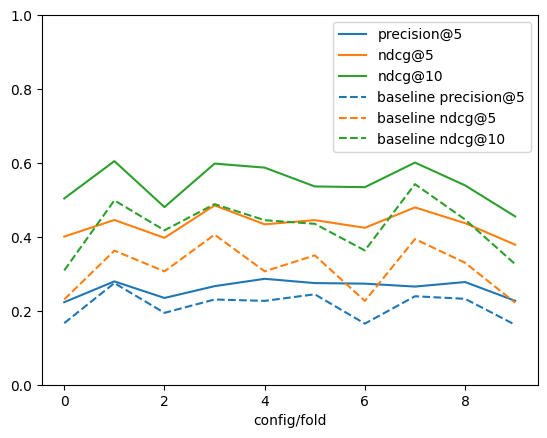

In [11]:
cols2plot = ['precision@5', 'ndcg@5', 'ndcg@10']

ax = best[cols2plot].plot()
ax.set_ylim(0, 1)

bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style='--', color=[l.get_color() for l in ax.lines])

best[cols2plot].describe()

In [12]:
best[['precision@5', 'ndcg@5', 'precision@10', 'ndcg@10']].mean()

precision@5     0.260974
ndcg@5          0.432875
precision@10    0.220342
ndcg@10         0.544189
dtype: float64

In [14]:
best.reset_index().to_csv(BEST_HPARAMS_FILE)

## Let's be realistic (repeating hparams per folds)

In [15]:
config_cols = [ c for c in best.columns if c.startswith('config/') ] # and c != 'config/iteration' ]

best_configs = best[config_cols].reset_index()
best_configs['config/fold'] = best_configs['config/fold'] + 1
best_configs_index = pd.MultiIndex.from_frame(best_configs)[:-1]

aux = rdf.set_index(['config/fold'] + config_cols)
realistic = aux.loc[aux.index.intersection(best_configs_index)]
realistic.to_csv(REALISTIC_HPARAMS_FILE)
realistic

loss  \
config/fold config/iteration config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                
1           10               128               300                  4                  0.0065               8.923120e-07  0.011395   
                                                                                                            8.923120e-07  0.011395   
2           10               128               215                  3                  0.0005               2.791926e-05  0.066600   
                                                                                                            2.791926e-05  0.066600   
3           5                512               5                    3                  0.2200               5.242816e-05  0.190800   
                                                                                                            5.242816e-05  0.190800   
4           5                128               300                  4                  0.0065               8.923120e-07  0.019055   
                                                                                                            8.923120e-07  0.019055   
5           5                512               5                    3                  0.2200               5.242816e-05  0.194097   
6           10               256               30                   5                  0.2347               2.860601e-05  0.503908   
                                                                                                            2.860601e-05  0.513284   
7           5                512               5                    3                  0.2200               5.242816e-05  0.192689   
8           10               256               30                   5                  0.2347               2.860601e-05  0.532431   
                                                                                                            2.860601e-05  0.530024   
9           10               128               300                  4                  0.0065               8.923120e-07  0.011145   
                                                                                                            8.923120e-07  0.011145   

                                                                                                                           mf_loss  \
config/fold config/iteration config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                
1           10               128               300                  4                  0.0065               8.923120e-07  0.011258   
                                                                                                            8.923120e-07  0.011258   
2           10               128               215                  3                  0.0005               2.791926e-05  0.065910   
                                                                                                            2.791926e-05  0.065910   
3           5                512               5                    3                  0.2200               5.242816e-05  0.185628   
                                                                                                            5.242816e-05  0.185627   
4           5                128               300                  4                  0.0065               8.923120e-07  0.018967   
                                                                                                            8.923120e-07  0.018967   
5           5                512               5                    3                  0.2200               5.242816e-05  0.188662   
6           10               256               30                   5                  0.2347               2.860601e-05  0.391008   
                                                                                                         

,precision@5,ndcg@5,ndcg@10
count,16.000000,16.000000,16.000000
mean,0.251935,0.407183,0.507451
std,0.020289,0.052639,0.050982
min,0.223611,0.353746,0.446619
25%,0.242578,0.367686,0.464076
50%,0.251740,0.380828,0.498273
75%,0.264505,0.443685,0.567877
max,0.288636,0.502043,0.579028


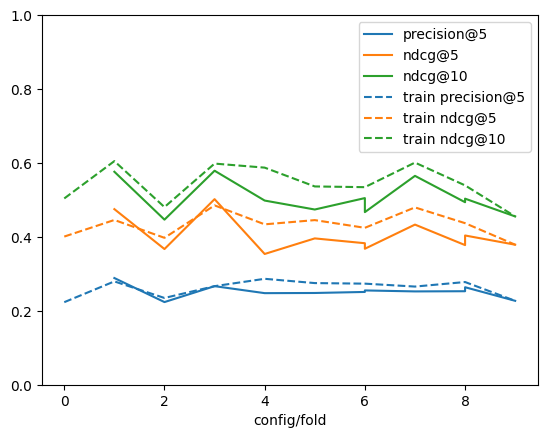

In [16]:
_toplot = realistic.reset_index().set_index('config/fold')

ax = _toplot[cols2plot].plot()
ax.set_ylim(0, 1)

best[cols2plot].rename(columns='train {}'.format).reset_index(drop=True).plot(ax=ax, style='--', color=[l.get_color() for l in ax.lines])
# bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style=':', color=[l.get_color() for l in ax.lines])

_toplot[cols2plot].describe()

## !!OLD GRAPHS!!

In [ ]:
config_cols = [ c for c in configs.columns if c.startswith('config/') ]
px.scatter(configs, x='ndcg@5', y='time_total_train', hover_data=config_cols)

In [ ]:
sns.swarmplot(configs, x='config/conv_layers', y='ndcg@5', hue='time_total_train', palette='flare')

In [ ]:
sns.swarmplot(configs, x='config/batch_size', y='ndcg@5', hue='time_total_train', palette='flare')
# plt.xscale('log', base=2)

In [ ]:
sns.violinplot(configs, x='config/batch_size', y='time_total_train', inner='point')

In [ ]:
sns.scatterplot(configs, x='config/learning_rate', y='ndcg@5', hue='time_total_train', palette='flare')
plt.xscale('log')

In [ ]:
sns.scatterplot(configs, x='config/l2', y='ndcg@5', hue='time_total_train', palette='flare')
plt.xscale('log')

In [ ]:
sns.scatterplot(configs, x='config/embedding_dim', y='ndcg@5', hue='time_total_train', palette='flare')